# Feature： Free Shipping Bar with $50 Threshold

## 1. get all packages and data we need

In [1]:
import pandas as pd
import math
import scipy.stats
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#download data here: https://drive.google.com/drive/folders/15fAv8MUw1J0k7FmRPNNK5NuseqGgSLhu?usp=sharing
df_test_overall = pd.read_csv('./visit-data.csv')
df_cateforymap = pd.read_csv('./category-mapping.csv')

## 2. check and filter data

In [3]:
#get data we need (test 2 data)
df_test = df_test_overall[df_test_overall['testid'] == 2]
df_test = df_test.merge(df_cateforymap, how = 'left', on = 'ChannelID')
df_test['Channel Name'] = df_test['Channel Name'].fillna('Undefined')

#have a overview of the dataset
df_test.shape

(6870668, 17)

In [4]:
#check if the numbers of control and varation group are almost equal
df_test.drop_duplicates(['ControlGroup','SessionID']).groupby(['ControlGroup'])['SessionID'].count()

ControlGroup
0    3436671
1    3433997
Name: SessionID, dtype: int64

In [5]:
#check each date's traffic size
df_test.drop_duplicates(['Date', 'SessionID']).groupby(['Date'])['SessionID'].count()

Date
2019-06-14        69
2019-06-15     59090
2019-06-16    127364
2019-06-17    137998
2019-06-18    173863
2019-06-19    194491
2019-06-20    193602
2019-06-21    200563
2019-06-22    199843
2019-06-23    193444
2019-06-24    180545
2019-06-25    222073
2019-06-26    266630
2019-06-27    248291
2019-06-28    257540
2019-06-29    252746
2019-06-30    233204
2019-07-01    199913
2019-07-02    242003
2019-07-03    298940
2019-07-04    305270
2019-07-05    669742
2019-07-06    363540
2019-07-07    290989
2019-07-08    239339
2019-07-09    275926
2019-07-10    358101
2019-07-11    332720
2019-07-12    152829
Name: SessionID, dtype: int64

In [6]:
#exclude the dates with much fewer traffic than others
df_test = df_test[pd.to_datetime(df_test['Date']) > pd.to_datetime('2019-06-15')]
df_test = df_test[pd.to_datetime(df_test['Date']) < pd.to_datetime('2019-07-12')]

In [7]:
df_test.head(5)

,Unnamed: 0,testid,ControlGroup,Date,SessionID,ChannelID,CategoryID,PlatformID,CusID,VisitorTypeID,Time,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted,Channel Name
0,0,2,1,2019-07-11,7685274065188263037,611,3,1,5299256406894404939,4,434,0,1,0,0,0,Email
1,1,2,1,2019-07-11,6449284229458809869,235,1,1,706543536253348169,4,338,0,1,0,0,0,FB - Paid
2,2,2,0,2019-07-11,509870060026686560,336,1,1,2082623938737374415,2,0,1,0,0,0,0,FB - Paid
3,3,2,1,2019-07-11,3589887684654054988,665,5,1,7908654078631292723,3,25,0,1,0,0,0,Google Ads
4,4,2,1,2019-07-11,7081653159511501375,2023,1,1,8078626604090692368,3,390,0,1,0,0,0,Retargeting


## 3. transform data to be prepared for analysis

In [8]:
df_result = df_test.drop_duplicates(['SessionID', 'ControlGroup']).groupby('ControlGroup')[['SessionID']].count()

In [9]:
df_result

,SessionID
ControlGroup,
0,3330657
1,3328023


In [10]:
a = df_test[df_test['Bounced'] == 1].drop_duplicates(['SessionID', 'ControlGroup']).groupby('ControlGroup')['SessionID'].count()

In [11]:
a.name = 'Bounced'

In [12]:
df_result = df_result.join(a)

In [13]:
df_result

,SessionID,Bounced
ControlGroup,,
0,3330657,647959
1,3328023,647615


In [14]:
#use a loop to get all metrics ready in df_result
metrics = ['Bounced', 'SawProduct', 'AddedToCart', 'ReachedCheckout', 'Converted']

df_result = df_test.drop_duplicates(['SessionID', 'ControlGroup']).groupby('ControlGroup')[['SessionID']].count()

for metric in metrics:
    a = df_test[df_test[metric] == 1].drop_duplicates(['SessionID', 'ControlGroup']).groupby('ControlGroup')['SessionID'].count()
    a.name = metric
    df_result = df_result.join(a)

df_result

,SessionID,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted
ControlGroup,,,,,,
0,3330657,647959,2435133,1040348,515454,377076
1,3328023,647615,2434424,1039177,514895,375873


## 4. define z test calculator

In [15]:
def z_test_calculator (df, denominator, numerator):
    
    #get the data
    control_denominator = df.loc[1, denominator]
    control_numerator = df.loc[1, numerator]
    var_denominator = df.loc[0, denominator]
    var_numerator = df.loc[0, numerator]
    
    #get the rate
    control_rate = control_numerator / control_denominator
    var_rate = var_numerator / var_denominator
    
    #STD (actually is square root of std^2/n, we do this because we can directly input it in the subsequent calculation)
    control_std = math.sqrt(abs(control_rate * (1 - control_rate) / control_denominator))
    var_std = math.sqrt(abs(var_rate * (1 - var_rate) / var_denominator))
    
    #z score
    z_score = (control_rate - var_rate) / math.sqrt(pow(control_std, 2) + pow(var_std, 2))
    
    #p value
    p_value = scipy.stats.norm.sf(abs(z_score))
    
    #lift
    perc_lift = (var_rate - control_rate) / control_rate
    abs_lift = var_rate - control_rate
    
    return (p_value, perc_lift, abs_lift)

## 5.1 execute calculations & export results as excel for overall data

In [16]:
data_types = ['SessionID', 'CusID']
dic_final = {}

metrics = ['Bounced', 'SawProduct', 'AddedToCart', 'ReachedCheckout', 'Converted']

for data_type in data_types:

    df_result = df_test.drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[[data_type]].count()

    for metric in metrics:
        a = df_test[df_test[metric] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[data_type].count()
        a.name = metric
        df_result = df_result.join(a)

    KPIs = [(data_type, 'SawProduct'), 
            (data_type, 'Bounced'),
            (data_type, 'AddedToCart'),
            (data_type, 'ReachedCheckout'),
            (data_type, 'Converted'),
            ('SawProduct', 'AddedToCart'),
            ('AddedToCart', 'ReachedCheckout'),
            ('ReachedCheckout', 'Converted')]

    df_final = pd.DataFrame()

    j = 0

    for i in KPIs:
        result = z_test_calculator (df_result, i[0], i[1])
        df_final.loc[j, 'demoninator'] = i[0]
        df_final.loc[j, 'numerator'] = i[1]
        df_final.loc[j, 'p_value'] = result[0]
        df_final.loc[j, 'perc_lift'] = result[1]
        df_final.loc[j, 'abs_lift'] = result[2]
        j = j + 1

    dic_final[data_type] = df_final

In [17]:
dic_final

{'SessionID':        demoninator        numerator   p_value  perc_lift  abs_lift
 0        SessionID       SawProduct  0.143623  -0.000500 -0.000366
 1        SessionID          Bounced  0.434493  -0.000260 -0.000051
 2        SessionID      AddedToCart  0.385398   0.000335  0.000105
 3        SessionID  ReachedCheckout  0.435553   0.000294  0.000045
 4        SessionID        Converted  0.134010   0.002407  0.000272
 5       SawProduct      AddedToCart  0.213188   0.000835  0.000357
 6      AddedToCart  ReachedCheckout  0.488272  -0.000041 -0.000020
 7  ReachedCheckout        Converted  0.038814   0.002113  0.001542,
 'CusID':        demoninator        numerator   p_value  perc_lift  abs_lift
 0            CusID       SawProduct  0.347091   0.000137  0.000130
 1            CusID          Bounced  0.370428   0.000667  0.000239
 2            CusID      AddedToCart  0.394116   0.000201  0.000161
 3            CusID  ReachedCheckout  0.240010   0.001141  0.000530
 4            CusID      

In [20]:
writer_overall = pd.ExcelWriter('test2_binomial_overall.xlsx')

for key in dic_final.keys():
    dic_final[key].to_excel(writer_overall, sheet_name = key)
    
writer_overall.save()

## 5.2 plot significance level reference line for overall data

In [18]:
df = df_test
denominator = 'ReachedCheckout'
numerator = 'Converted'
data_type = 'SessionID'

#get daily data
if denominator == data_type:
    denominator_dailydata = df.drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count()

elif denominator != data_type:    
    denominator_dailydata = df[df[denominator] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count()    

numerator_dailydata = df[df[numerator] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count()

In [19]:
#name them
denominator_dailydata.name = denominator
numerator_dailydata.name = numerator

In [22]:
denominator_dailydata.head(10)

Date        ControlGroup
2019-06-16  0               15456
            1               15244
2019-06-17  0               16005
            1               15922
2019-06-18  0               19319
            1               19437
2019-06-19  0               18479
            1               18065
2019-06-20  0               16509
            1               16849
Name: ReachedCheckout, dtype: int64

In [24]:
#reset index
denominator_aggdailydata = denominator_dailydata.reset_index()
numerator_aggdailydata = numerator_dailydata.reset_index()

In [25]:
denominator_aggdailydata.head(10)

,Date,ControlGroup,ReachedCheckout
0,2019-06-16,0,15456
1,2019-06-16,1,15244
2,2019-06-17,0,16005
3,2019-06-17,1,15922
4,2019-06-18,0,19319
5,2019-06-18,1,19437
6,2019-06-19,0,18479
7,2019-06-19,1,18065
8,2019-06-20,0,16509
9,2019-06-20,1,16849


In [26]:
#replace denominator/numearator_aggdailydata's original denominator/ numerator column data with cumsum data
denominator_aggdailydata[denominator] = denominator_aggdailydata.groupby('ControlGroup')[denominator].cumsum()
numerator_aggdailydata[numerator] = numerator_aggdailydata.groupby('ControlGroup')[numerator].cumsum()

In [27]:
denominator_aggdailydata.head(10)

,Date,ControlGroup,ReachedCheckout
0,2019-06-16,0,15456
1,2019-06-16,1,15244
2,2019-06-17,0,31461
3,2019-06-17,1,31166
4,2019-06-18,0,50780
5,2019-06-18,1,50603
6,2019-06-19,0,69259
7,2019-06-19,1,68668
8,2019-06-20,0,85768
9,2019-06-20,1,85517


In [28]:
#calculate p value, perc lift & abs lift for every day by using loop and z test calculator, and then fill them in df_cumsum
df_cumsum = pd.DataFrame()

for date in df.drop_duplicates('Date')['Date'].tolist():
    df_result = denominator_aggdailydata[denominator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True)
    df_result = df_result.merge(numerator_aggdailydata[numerator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True), on = ['Date', 'ControlGroup'])

    sig_result = z_test_calculator(df_result, denominator, numerator)
    df_cumsum.loc[date, 'sig_level'] = 1 - sig_result[0]
    df_cumsum.loc[date, 'perc_lift'] = sig_result[1]
    df_cumsum.loc[date, 'abs_lift'] =  sig_result[2]

df_cumsum.sort_index()

,sig_level,perc_lift,abs_lift
2019-06-16,0.878518,-0.008328,-0.006000
2019-06-17,0.791068,-0.003988,-0.002894
2019-06-18,0.613731,0.001106,0.000807
2019-06-19,0.776221,0.002528,0.001828
2019-06-20,0.855780,0.003200,0.002302
2019-06-21,0.797605,0.002311,0.001660
2019-06-22,0.924754,0.003731,0.002674
2019-06-23,0.928849,0.003585,0.002571
2019-06-24,0.934378,0.003476,0.002500
2019-06-25,0.944942,0.003431,0.002479


Text(0, 0.5, 'sig_level')

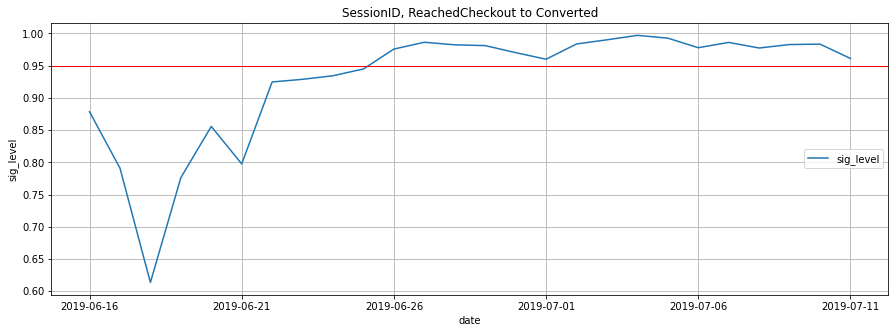

In [29]:
#plot
ax = df_cumsum.sort_index()['sig_level'].plot(figsize = (15, 5))
ax.axhline(y = 0.95, linewidth = 1, color = 'r')
ax.title
ax.grid(True)
ax.legend(loc = 'right')
ax.set_title(data_type + ', ' + denominator + ' to ' + numerator)
ax.set_xlabel('date')
ax.set_ylabel('sig_level')

## 6.1 execute calculations & export results as excel for data in different cuts 

### steps are similar with 5.1, so I won't repeat the step by step process

In [30]:
df = df_test
data_types = ['SessionID', 'CusID']
cuts = ['CategoryID', 'VisitorTypeID', 'Channel Name']

dic_final_cut = {}
df_cut = df.copy()

for data_type in data_types:
    
    for cut in cuts:

        for p in set(df_cut[cut]):

            df = df_cut[df_cut[cut] == p]

            metrics = ['SawProduct', 'Bounced', 'AddedToCart', 'ReachedCheckout', 'Converted']

            df_result = df.drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[[data_type]].count()

            for metric in metrics:
                a = df[df[metric] == 1].drop_duplicates([data_type, 'ControlGroup']).groupby('ControlGroup')[data_type].count()
                a.name = metric
                df_result = df_result.join(a)

            KPIs = [(data_type, 'SawProduct'), 
                    (data_type, 'Bounced'),
                    (data_type, 'AddedToCart'),
                    (data_type, 'ReachedCheckout'),
                    (data_type, 'Converted'),
                    ('SawProduct', 'Bounced'),
                    ('SawProduct', 'AddedToCart'),
                    ('AddedToCart', 'ReachedCheckout'),
                    ('ReachedCheckout', 'Converted')]

            df_final_cut = pd.DataFrame()
            j = 0

            for i in KPIs:
                result = z_test_calculator (df_result, i[0], i[1])
                df_final_cut.loc[j, 'demoninator'] = i[0]
                df_final_cut.loc[j, 'numerator'] = i[1]
                df_final_cut.loc[j, 'p_value'] = result[0]
                df_final_cut.loc[j, 'perc_lift'] = result[1]
                df_final_cut.loc[j, 'abs_lift'] = result[2]
                j = j + 1

            dic_final_cut[data_type + '_'+ cut + '_' + str(p)] = df_final_cut

In [62]:
dic_final_cut

{'SessionID_CategoryID_1':        demoninator        numerator   p_value  perc_lift  abs_lift
 0        SessionID       SawProduct  0.402785  -0.000179 -0.000114
 1        SessionID          Bounced  0.405710   0.000526  0.000085
 2        SessionID      AddedToCart  0.158482   0.001407  0.000450
 3        SessionID  ReachedCheckout  0.348406   0.000831  0.000141
 4        SessionID        Converted  0.093400   0.003386  0.000420
 5       SawProduct          Bounced  0.367505   0.000705  0.000177
 6       SawProduct      AddedToCart  0.093881   0.001586  0.000795
 7      AddedToCart  ReachedCheckout  0.359899  -0.000575 -0.000305
 8  ReachedCheckout        Converted  0.036010   0.002552  0.001865,
 'SessionID_CategoryID_2':        demoninator        numerator   p_value  perc_lift  abs_lift
 0        SessionID       SawProduct  0.347950  -0.000339 -0.000302
 1        SessionID          Bounced  0.142574  -0.004578 -0.001156
 2        SessionID      AddedToCart  0.214157  -0.002947 -0.00

In [ ]:
writer_cut = pd.ExcelWriter('test2_binomial_cut.xlsx')

for key in dic_final_cut.keys():
    dic_final_cut[key].to_excel(writer_cut, sheet_name = key)
    
writer_cut.save()

## 6.2 plot significance level reference line for overall data in different cuts

### steps are similar with 6.1, so I won't repeat the step by step process

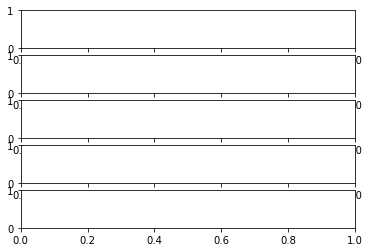

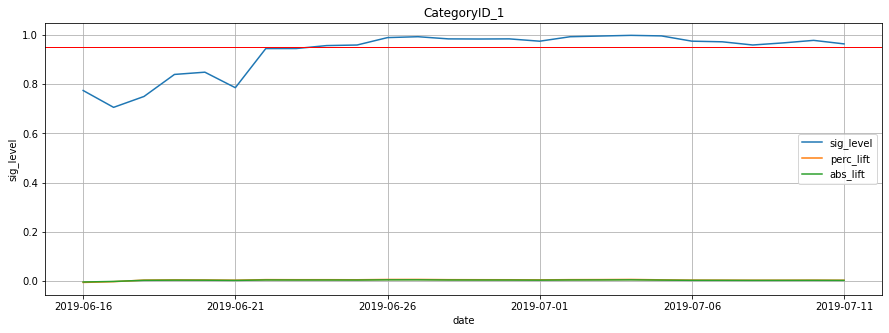

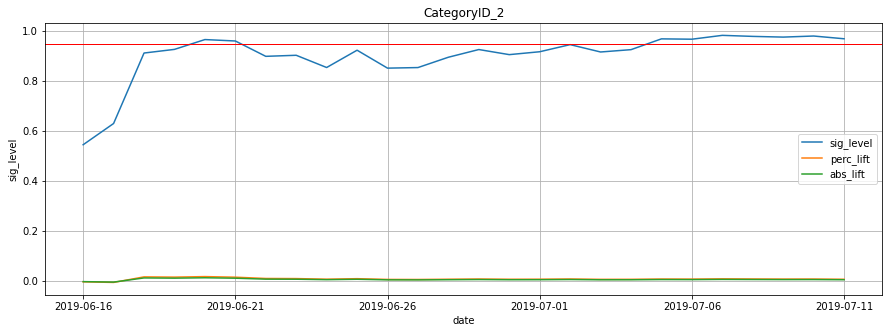

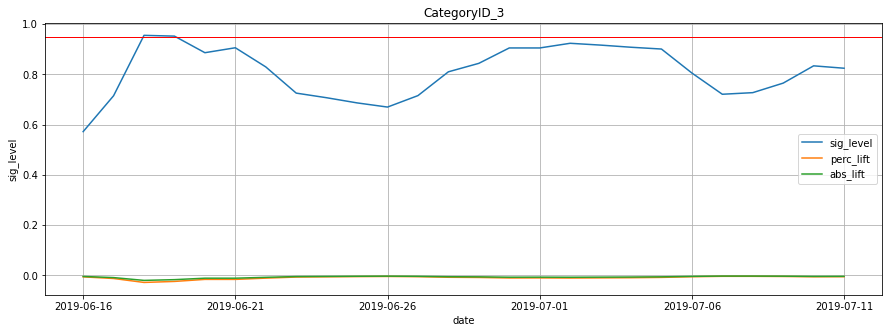

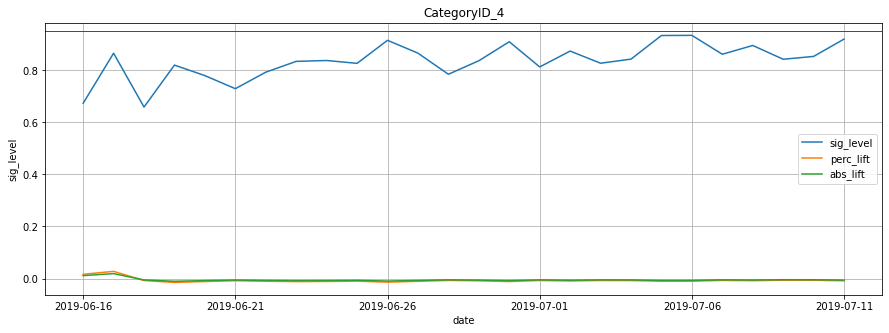

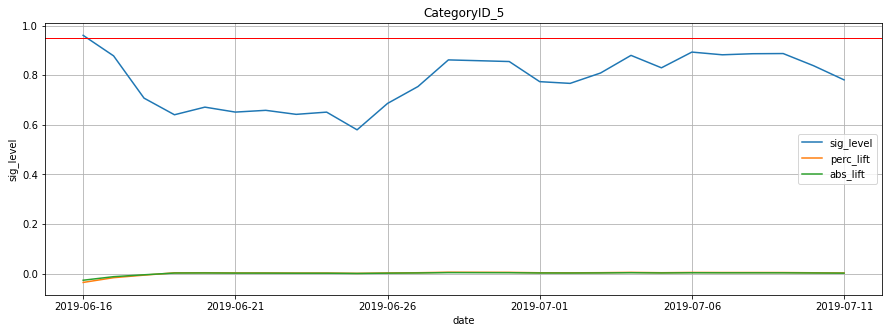

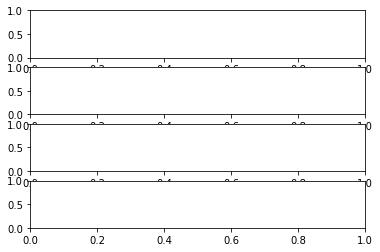

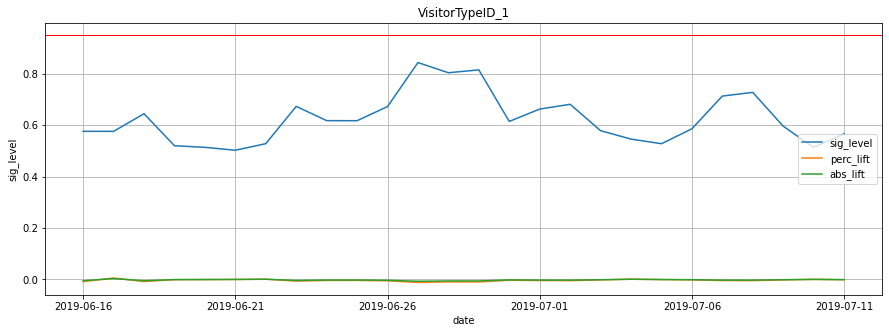

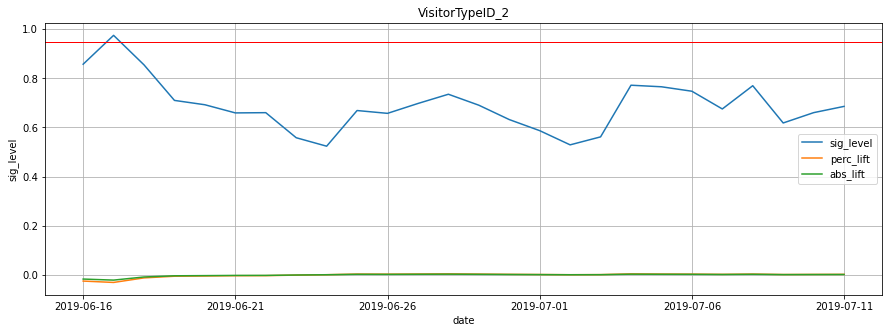

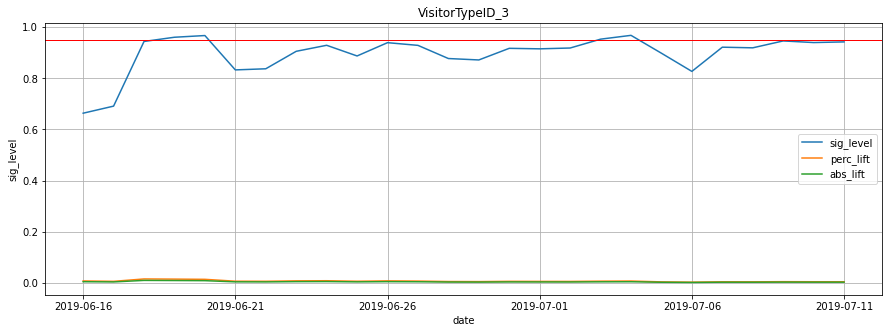

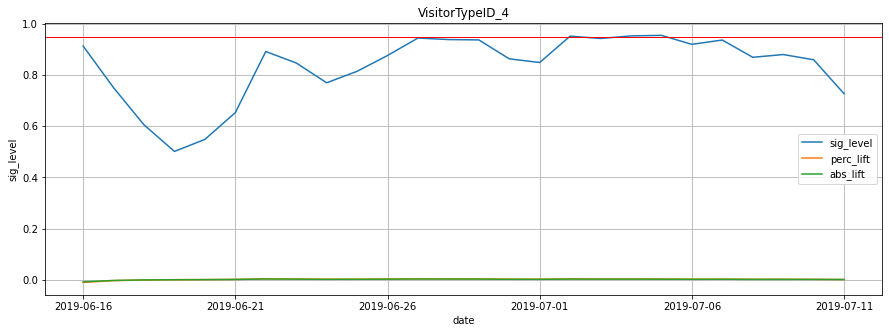

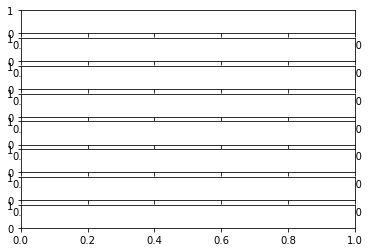

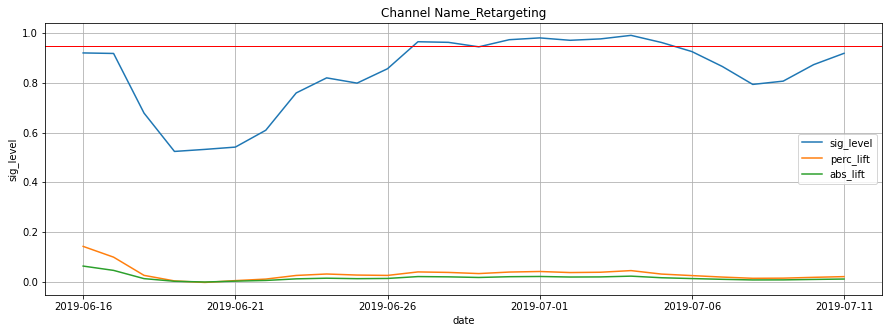

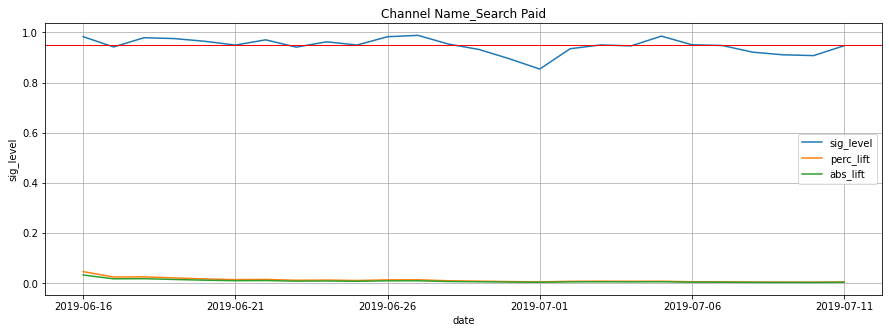

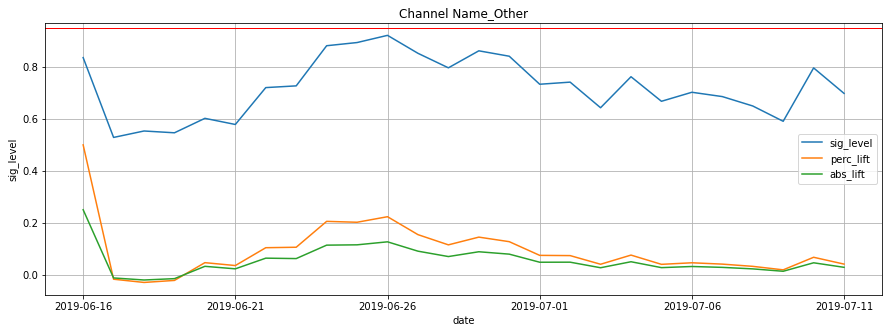

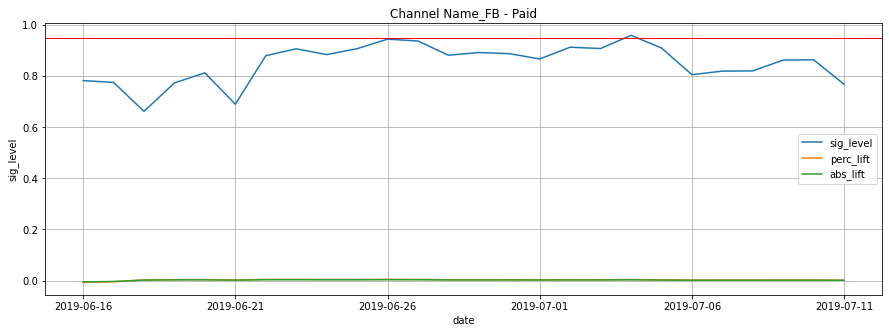

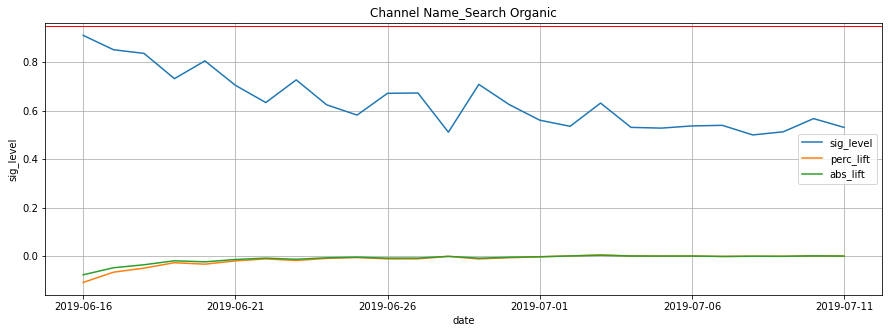

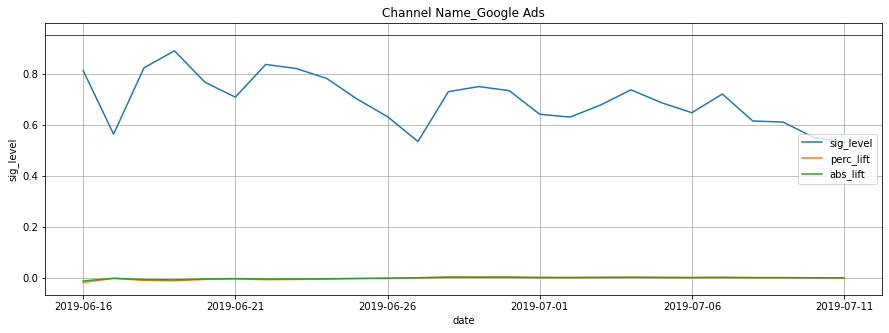

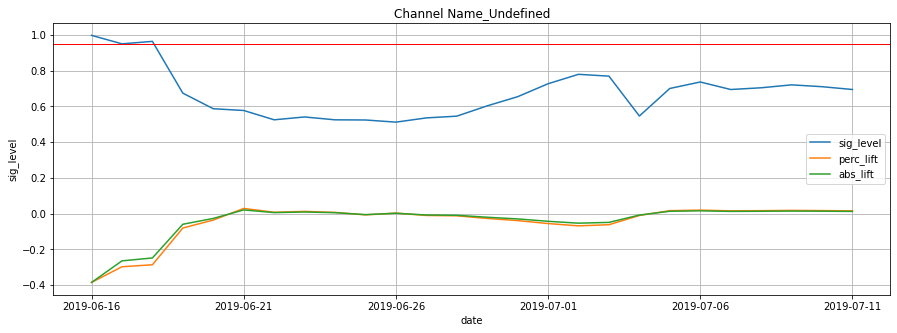

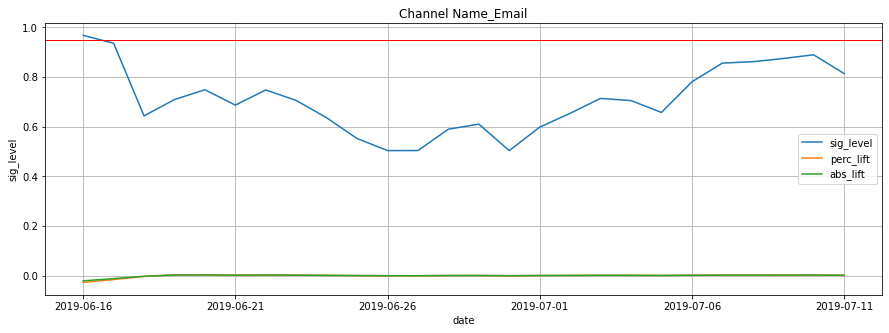

In [31]:
df = df_test
denominator = 'ReachedCheckout'
numerator = 'Converted'
data_type = 'SessionID'
cuts = ['CategoryID', 'VisitorTypeID', 'Channel Name']

dic_cumsum_cut = {}

for cut in cuts:

    j = 0

    fig, ax = plt.subplots(len(set(df[cut])))

    for p in set(df[cut]):

        if denominator == data_type:
            denominator_dailydata = df[df[cut] == p].drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count().unstack(fill_value = 0).stack()

        elif denominator != data_type:
            denominator_dailydata = df[(df[cut] == p) & (df[denominator] == 1)].drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count().unstack(fill_value = 0).stack()

        numerator_dailydata = df[(df[cut] == p) & (df[numerator] == 1)].drop_duplicates([data_type, 'ControlGroup']).groupby(['Date', 'ControlGroup'])[data_type].count().unstack(fill_value = 0).stack()

        denominator_dailydata.name = denominator
        numerator_dailydata.name = numerator

        denominator_aggdailydata = denominator_dailydata.reset_index()
        numerator_aggdailydata = numerator_dailydata.reset_index()

        denominator_aggdailydata[denominator] = denominator_aggdailydata.groupby('ControlGroup')[denominator].cumsum()
        numerator_aggdailydata[numerator] = numerator_aggdailydata.groupby('ControlGroup')[numerator].cumsum()

        df_cumsum_cut = pd.DataFrame()

        for date in df.drop_duplicates('Date')['Date'].tolist():
            df_result = denominator_aggdailydata[denominator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True)
            df_result = df_result.merge(numerator_aggdailydata[numerator_aggdailydata['Date'] == date].set_index('ControlGroup', drop = True), on = ['Date', 'ControlGroup'])

            sig_result = z_test_calculator(df_result, denominator, numerator)
            df_cumsum_cut.loc[date, 'sig_level'] = 1 - sig_result[0]
            df_cumsum_cut.loc[date, 'perc_lift'] = sig_result[1]
            df_cumsum_cut.loc[date, 'abs_lift'] =  sig_result[2]

        dic_cumsum_cut[cut + str(p)] = df_cumsum_cut.sort_index()

        ax[j] = dic_cumsum_cut[cut + str(p)].plot(figsize = (15, 5))
        ax[j].axhline(y = 0.95, linewidth = 1, color = 'r')

        ax[j].grid(True)
        ax[j].legend(loc = 'right')
        ax[j].set_title(cut+ '_' + str(p))
        ax[j].set_xlabel('date')
        ax[j].set_ylabel('sig_level')

        j = j + 1